In [2]:
!unzip archive\ \(3\).zip

Streaming output truncated to the last 5000 lines.
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-43-15.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-46-17.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-46-28.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-46-51.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-48-33.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-51-12.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-57-50.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_08-59-44.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-01-38.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-05-13.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-05-25.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-06-44.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-08-04.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-13-10.jpg  
  inflating: Warp-D/train/images/POSAD_1_11-Sep_09-15-49.jpg  
  in

In [1]:
# Cell 1: Install dependencies
!pip install -q ultralytics opencv-python matplotlib


In [ ]:
# Cell 2: Imports & configuration

from pathlib import Path
import os
import textwrap
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

# === EDIT THIS PATH FOR YOUR MACHINE ===
DATA_ROOT = Path("C:\Users\kyjac\Documents\SPTFinal\WaRP Dataset\Warp-D") # Path to WaRP-D root folder
assert DATA_ROOT.exists(), f"DATA_ROOT does not exist: {DATA_ROOT}"

print("Using dataset root:", DATA_ROOT)

# Paths inside WaRP-D
train_images_dir = DATA_ROOT / "train" / "images"
train_labels_dir = DATA_ROOT / "train" / "labels"
val_images_dir   = DATA_ROOT / "test" / "images"
val_labels_dir   = DATA_ROOT / "test" / "labels"

for p in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
    assert p.exists(), f"Missing folder: {p}"


Using dataset root: /content/WaRP Dataset/Warp-D


In [3]:
# Cell 3: Read classes.txt and build warp.yaml for YOLO

classes_file = DATA_ROOT / "classes.txt"
assert classes_file.exists(), f"classes.txt not found at {classes_file}"

with open(classes_file, "r") as f:
    class_names = [line.strip() for line in f.readlines() if line.strip()]

num_classes = len(class_names)
print(f"Found {num_classes} classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

# Build YAML config for Ultralytics
data_yaml_path = Path("warp.yaml")

yaml_str = "path: " + str(DATA_ROOT) + "\n"
yaml_str += "train: train/images\n"
yaml_str += "val: test/images\n"
yaml_str += "names:\n"
for i, name in enumerate(class_names):
    yaml_str += f"  {i}: {name}\n"

with open(data_yaml_path, "w") as f:
    f.write(yaml_str)

print("\nSaved YOLO data config to:", data_yaml_path.resolve())
print("\n--- warp.yaml ---")
print(yaml_str)


Found 28 classes:
0: bottle-blue
1: bottle-green
2: bottle-dark
3: bottle-milk
4: bottle-transp
5: bottle-multicolor
6: bottle-yogurt
7: bottle-oil
8: cans
9: juice-cardboard
10: milk-cardboard
11: detergent-color
12: detergent-transparent
13: detergent-box
14: canister
15: bottle-blue-full
16: bottle-transp-full
17: bottle-dark-full
18: bottle-green-full
19: bottle-multicolorv-full
20: bottle-milk-full
21: bottle-oil-full
22: detergent-white
23: bottle-blue5l
24: bottle-blue5l-full
25: glass-transp
26: glass-dark
27: glass-green

Saved YOLO data config to: /content/warp.yaml

--- warp.yaml ---
path: /content/WaRP Dataset/Warp-D
train: train/images
val: test/images
names:
  0: bottle-blue
  1: bottle-green
  2: bottle-dark
  3: bottle-milk
  4: bottle-transp
  5: bottle-multicolor
  6: bottle-yogurt
  7: bottle-oil
  8: cans
  9: juice-cardboard
  10: milk-cardboard
  11: detergent-color
  12: detergent-transparent
  13: detergent-box
  14: canister
  15: bottle-blue-full
  16: bottle-

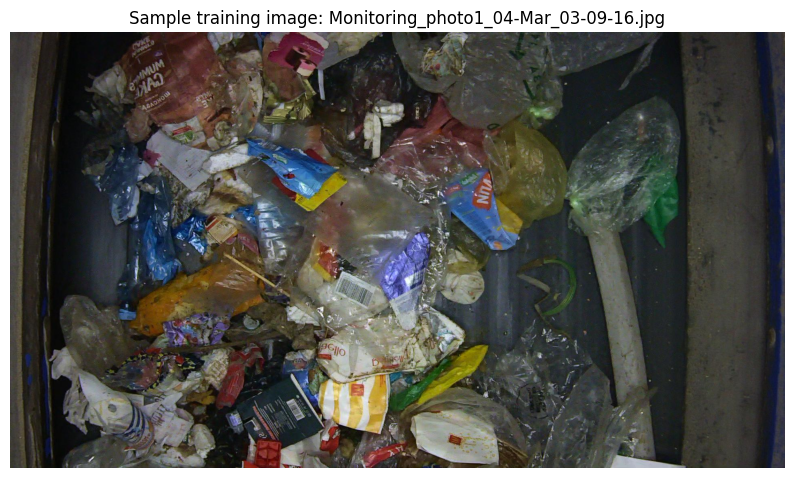

In [4]:
# Cell 4: Quick sanity check image

sample_imgs = sorted(train_images_dir.glob("*.jpg")) + sorted(train_images_dir.glob("*.png"))
assert len(sample_imgs) > 0, "No images found in train/images."

img_path = sample_imgs[0]
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Sample training image: {img_path.name}")
plt.show()


In [5]:
!nvidia-smi


Wed Dec  3 20:41:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import re, torch, random, numpy as np

# ---------------------------
# 1) Reproducibility
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------------------
# 2) Device selection
# ---------------------------
use_cuda = torch.cuda.is_available()
device = "0" if use_cuda else "cpu"
print("torch.cuda.is_available():", use_cuda)
print("Selected device:", device)

# ---------------------------
# 3) Data config
# ---------------------------
data_yaml_path = Path("warp.yaml")
assert data_yaml_path.exists(), "warp.yaml not found."

# ---------------------------
# 4) Model selection
# ---------------------------
model_name = "yolov8m.pt" if use_cuda else "yolov8s.pt"
model_stem = Path(model_name).stem  # e.g., 'yolov8m'
print("Using model:", model_stem)

# ---------------------------
# 5) Auto-increment run name
# Pattern: <model>_warp_<device>_v#
# Example: yolov8m_warp_0_v1
# ---------------------------

runs_root = Path("runs/warp_yolov8")
runs_root.mkdir(parents=True, exist_ok=True)

pattern = re.compile(rf"{model_stem}_warp_{device}_v(\d+)$")

existing_versions = []
for d in runs_root.iterdir():
    if d.is_dir():
        m = pattern.match(d.name)
        if m:
            existing_versions.append(int(m.group(1)))

next_version = max(existing_versions) + 1 if existing_versions else 1
run_name = f"{model_stem}_warp_{device}_v{next_version}"

print("Auto-selected run name:", run_name)

# ---------------------------
# 6) Hyperparameters
# ---------------------------
if use_cuda:
    EPOCHS   = 120
    IMGSZ    = 768
    BATCH    = 12
    PATIENCE = 40
else:
    EPOCHS   = 30
    IMGSZ    = 416
    BATCH    = 4
    PATIENCE = 10

print(f"Hyperparams -> epochs={EPOCHS}, imgsz={IMGSZ}, batch={BATCH}, patience={PATIENCE}")

# ---------------------------
# 7) Load model & Train
# ---------------------------
model = YOLO(model_name)

results = model.train(
    data=str(data_yaml_path),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    patience=PATIENCE,
    lr0=0.005,
    project=str(runs_root),
    name=run_name,
    exist_ok=True,
    device=device,
)

best_weights = Path(results.save_dir) / "weights" / "best.pt"
print("\n\n== Training Complete ==")
print("Run folder:", results.save_dir)
print("Best weights saved at:", best_weights)


torch.cuda.is_available(): True
Selected device: 0
Using model: yolov8m
Auto-selected run name: yolov8m_warp_0_v1
Hyperparams -> epochs=120, imgsz=768, batch=12, patience=40
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.4.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=warp.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_sca

In [9]:
# Cell 6: Evaluate trained model

best_weights = Path("/content/runs/warp_yolov8/yolov8s_warp_0/weights/best.pt")
model = YOLO(str(best_weights))
metrics = model.val(data=str(data_yaml_path), imgsz=IMGSZ)

print("\n=== Validation Metrics ===")
print(f"mAP@0.5:      {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Precision:    {metrics.box.mp:.3f}")
print(f"Recall:       {metrics.box.mr:.3f}")



Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.4.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,136,420 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3430.5±1317.8 MB/s, size: 301.5 KB)
val: Scanning /content/WaRP Dataset/Warp-D/test/labels.cache... 522 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 522/522 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 3.6it/s 9.2s
                   all        522       1551      0.552      0.544      0.531      0.408
           bottle-blue         87        104      0.497      0.446      0.492      0.375
          bottle-green         65         74      0.632      0.689      0.667      0.514
           bottle-dark         80         95      0.747      0.737       0.78      0.602
           bottle-milk         54         57      0.517      0.439      0.413      0.315
         bottle-transp        164  

In [14]:
from collections import defaultdict
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Map class names to super-categories (same as before, just no ROI logic)
def map_super_category(class_name: str) -> str:
    name = class_name.lower()
    if name.startswith("bottle-") or "bottle" in name or name.startswith("glass-"):
        return "bottle"
    if "cardboard" in name or "carton" in name:
        return "cardboard"
    if "detergent" in name:
        return "detergent"
    if "canister" in name:
        return "canister"
    if "cans" in name or name.startswith("cans"):
        return "metal_can"
    return "other"


# Value per detected item (you can tweak these for your report)
SUPER_CATEGORY_VALUE = {
    "bottle":     0.05,
    "cardboard":  0.02,
    "detergent":  0.03,
    "canister":   0.04,
    "metal_can":  0.05,
    "other":      0.00,
}


def analyze_frame_simple(
    model,
    image_path: str,
    class_names: list,
    conf_thres: float = 0.25,
):
    """
    Run detection on a single image, count items, estimate value.
    No ROI, no sorted/missed – just 'what recyclables are present in this frame?'.
    """
    img_bgr = cv2.imread(image_path)
    assert img_bgr is not None, f"Failed to read image: {image_path}"
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Run YOLO inference
    results = model(source=img_rgb, verbose=False)[0]

    detections = []
    counts_by_class = defaultdict(int)
    counts_by_super = defaultdict(int)

    total_value = 0.0

    for box in results.boxes:
        conf = float(box.conf.item())
        if conf < conf_thres:
            continue

        cls_id = int(box.cls.item())
        class_name = class_names[cls_id]
        x1, y1, x2, y2 = box.xyxy[0].tolist()

        super_cat = map_super_category(class_name)
        item_value = SUPER_CATEGORY_VALUE.get(super_cat, 0.0)

        detections.append(
            {
                "class_id": cls_id,
                "class_name": class_name,
                "super_category": super_cat,
                "conf": conf,
                "bbox": (x1, y1, x2, y2),
                "value": item_value,
            }
        )

        counts_by_class[class_name] += 1
        counts_by_super[super_cat] += 1
        total_value += item_value

    total_items = len(detections)
    has_recycling = total_items > 0

    # Draw a simple visualization (all boxes same color)
    vis = img_rgb.copy()
    for d in detections:
        x1, y1, x2, y2 = map(int, d["bbox"])
        label = f"{d['class_name']} {d['conf']:.2f}"
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            vis,
            label,
            (x1, max(0, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    stats = {
        "total_items": total_items,
        "has_recycling": has_recycling,
        "total_value": total_value,
        "counts_by_class": dict(counts_by_class),
        "counts_by_super": dict(counts_by_super),
        "detections": detections,
    }

    return vis, stats


Analyzing image: /content/WaRP Dataset/Warp-D/test/images/Monitoring_photo2_04-Mar_00-47-42.jpg


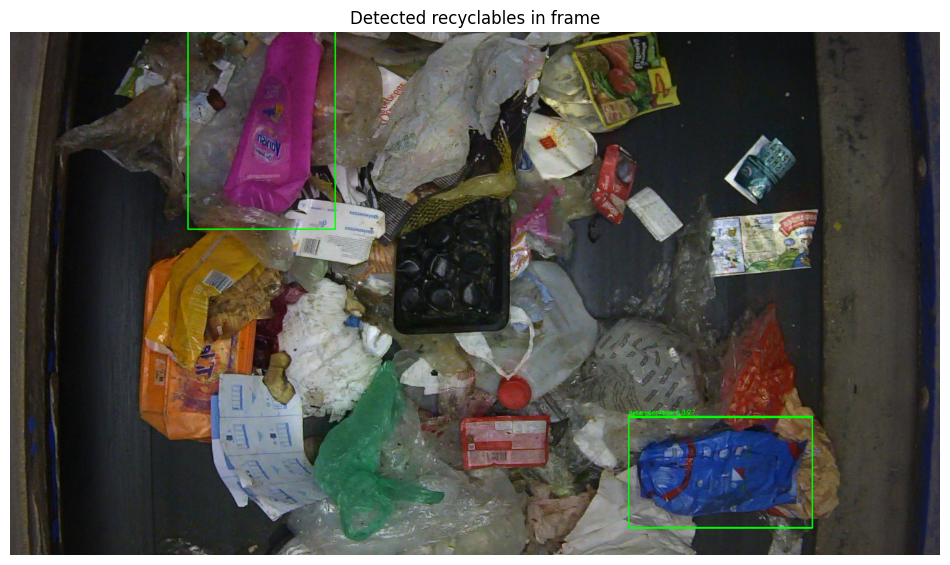

=== Frame Recycling Stats ===
Has recycling in frame?: True
Total items detected:    3
Estimated total value (CAD): 0.08

Counts by super-category:
  detergent: 2
  cardboard: 1

Counts by class:
  detergent-color: 1
  detergent-box: 1
  juice-cardboard: 1


In [15]:
# Use the trained model you loaded from best.pt
from pathlib import Path

best_weights = Path("runs/warp_yolov8/yolov8s_warp_0/weights/best.pt")
assert best_weights.exists()
model = YOLO(str(best_weights))

# Example: use a sample from test set
val_imgs = sorted(val_images_dir.glob("*.jpg")) + sorted(val_images_dir.glob("*.png"))
assert val_imgs, "No images found in val_images_dir"
test_img_path = str(val_imgs[0])
print("Analyzing image:", test_img_path)

vis_img, stats = analyze_frame_simple(
    model=model,
    image_path=test_img_path,
    class_names=class_names,
    conf_thres=0.25,
)

plt.figure(figsize=(12, 7))
plt.imshow(vis_img)
plt.axis("off")
plt.title("Detected recyclables in frame")
plt.show()

print("=== Frame Recycling Stats ===")
print("Has recycling in frame?:", stats["has_recycling"])
print("Total items detected:   ", stats["total_items"])
print(f"Estimated total value (CAD): {stats['total_value']:.2f}")

print("\nCounts by super-category:")
for k, v in stats["counts_by_super"].items():
    print(f"  {k}: {v}")

print("\nCounts by class:")
for k, v in stats["counts_by_class"].items():
    print(f"  {k}: {v}")


In [19]:
# Cell 10: Save trained model for deployment

deploy_dir = Path("deploy_models")
deploy_dir.mkdir(exist_ok=True)
deploy_weights = deploy_dir / "warp_yolov8n_best.pt"

import shutil
shutil.copy(best_weights, deploy_weights)

print("Saved deployment model to:", deploy_weights.resolve())


Saved deployment model to: /content/deploy_models/warp_yolov8n_best.pt
